### References : https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html

### Define a Model

In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

In [2]:
import torch
torch.manual_seed(42) # Setting the seed
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class Classifier(nn.Module):
  def __init__(self,num_inputs,num_outputs,num_hidden):
    super().__init__()
    self.linear1 = nn.Linear(num_inputs,num_hidden)
    self.act_fn = nn.Tanh()
    self.linear2 = nn.Linear(num_hidden, num_outputs)

  def forward(self,x):
    x = self.linear1(x)
    x = self.act_fn(x)
    x = self.linear2(x)

    return x


In [4]:
model = Classifier(num_inputs=2, num_outputs=1,num_hidden=4)
# Printing a module shows all its submodules
print(model)

Classifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [5]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


### Make Datasets

In [6]:
import torch.utils.data as data

In [7]:
class XORDataset(data.Dataset):
  def __init__(self,size,std = 0.1):
    super().__init__()
    self.size = size
    self.std = std  
    self.generate_continuous_xor()

  def generate_continuous_xor(self):
    data = torch.randint(low = 0,high=2,size = (self.size,2),dtype = torch.float32)
    label = (data.sum(dim=1) == 1).to(torch.long)
    data += self.std * torch.randn(data.shape)

    self.data = data
    self.label = label  

  def __len__(self):
    return self.size  
  

  def __getitem__(self,idx):
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label


In [8]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.8675, 0.9484]), tensor(0))


In [9]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

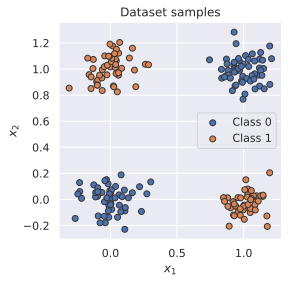

In [10]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [11]:
### Dataloader class
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [12]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 1.1953,  0.2049],
        [-0.1459,  0.8506],
        [-0.1253,  0.1119],
        [ 0.0531, -0.1361],
        [ 0.1345,  0.0127],
        [-0.1449,  0.9395],
        [ 1.0506,  0.9082],
        [ 1.0080,  0.0745]])
Data labels torch.Size([8]) 
 tensor([1, 1, 0, 0, 0, 1, 0, 1])


In [13]:
loss_module = nn.BCEWithLogitsLoss()
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
                            

### Model Training

In [14]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [16]:
# Push model to device. Has to be only done once
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [17]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

In [18]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 2.2680,  2.2159],
        [-3.4127,  2.4905],
        [-0.2947, -0.1366],
        [-2.2528,  3.2508]])), ('linear1.bias', tensor([-0.4080, -0.9470,  0.7039,  0.8016])), ('linear2.weight', tensor([[ 3.2733,  4.3679,  0.5540, -4.3394]])), ('linear2.bias', tensor([1.0851]))])


In [20]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

In [22]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = Classifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[ 2.2680,  2.2159],
        [-3.4127,  2.4905],
        [-0.2947, -0.1366],
        [-2.2528,  3.2508]])), ('linear1.bias', tensor([-0.4080, -0.9470,  0.7039,  0.8016])), ('linear2.weight', tensor([[ 3.2733,  4.3679,  0.5540, -4.3394]])), ('linear2.bias', tensor([1.0851]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[ 2.2680,  2.2159],
        [-3.4127,  2.4905],
        [-0.2947, -0.1366],
        [-2.2528,  3.2508]])), ('linear1.bias', tensor([-0.4080, -0.9470,  0.7039,  0.8016])), ('linear2.weight', tensor([[ 3.2733,  4.3679,  0.5540, -4.3394]])), ('linear2.bias', tensor([1.0851]))])


In [23]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [24]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [25]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%
